1.IMPORTING LIBRARIES

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

2.  LOADING DATA AND DEFINING FEATURES


In [2]:
df = pd.read_csv('enhanced_dataset_for_modelling.csv')
df = df.dropna()             # drop any missing rows

X = df.drop(columns=['CPI']) # all columns except target
y = df['CPI']

3.  TRAIN AND TEST SPLIT

In [5]:
# 80% train / 20% test (no shuffle for time series)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False)

# Drop the 'Date' column as it's not a numerical feature
X_train = X_train.drop(columns=['Date'])
X_test = X_test.drop(columns=['Date'])

# standardize inputs
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

RIDGE REGRESSION TRAINING DEFAULT

In [6]:
ridge_def = Ridge()
ridge_def.fit(X_train_scaled, y_train)

y_tr_def = ridge_def.predict(X_train_scaled)
y_te_def = ridge_def.predict(X_test_scaled)

def print_metrics(label, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{label:6} → RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")

print("Ridge (default) Performance")
print_metrics(" Train", y_train, y_tr_def)
print_metrics(" Test ", y_test,  y_te_def)

Ridge (default) Performance
 Train → RMSE: 0.312, MAE: 0.236, R²: 0.989
 Test  → RMSE: 0.652, MAE: 0.508, R²: 0.987


5.   RIDGE REGRESSION TUNING

In [7]:
import numpy as np
import pandas as pd
import math

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Build a leak-proof pipeline: scaling → ridge
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge",  Ridge())
])

# 2. Hyperparameter grid: alpha from 1e-3 to 1e3
param_grid = {
    "ridge__alpha": np.logspace(-3, 3, 13)
}

# 3. TimeSeriesSplit to respect temporal order
cv_split = TimeSeriesSplit(n_splits=4)

# 4. Track multiple metrics; refit on best RMSE
scoring = {
    "rmse": "neg_root_mean_squared_error",
    "mae":  "neg_mean_absolute_error",
    "r2":   "r2"
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv_split,
    scoring=scoring,
    refit="rmse",
    return_train_score=True,
    n_jobs=-1
)

# 5. Fit on your training data
grid_search.fit(X_train, y_train)

# 6. Pull out the best alpha and model
best_alpha = grid_search.best_params_["ridge__alpha"]
best_model = grid_search.best_estimator_

print(f"Optimal alpha (by CV RMSE): {best_alpha:.4f}")

# 7. Final evaluation on train & test sets
y_pred_train = best_model.predict(X_train)
y_pred_test  = best_model.predict(X_test)

results = {
    "R2_train":  r2_score(y_train, y_pred_train),
    "R2_test":   r2_score(y_test,  y_pred_test),
    "MAE_test":  mean_absolute_error(y_test,  y_pred_test),
    "RMSE_test": math.sqrt(mean_squared_error(y_test, y_pred_test))
}

print("\nFinal evaluation on hold-out set:")
for metric, val in results.items():
    print(f"  {metric}: {val:.4f}")

# 8. (Optional) Inspect CV summaries for deeper diagnostics
cv_df = pd.DataFrame(grid_search.cv_results_)[[
    "param_ridge__alpha",
    "mean_train_rmse", "mean_test_rmse",
    "mean_train_r2",   "mean_test_r2"
]].sort_values("param_ridge__alpha")

print("\nCross-validation summary by alpha:")
print(cv_df.to_string(index=False))

Optimal alpha (by CV RMSE): 0.0010

Final evaluation on hold-out set:
  R2_train: 0.9902
  R2_test: 0.9559
  MAE_test: 0.8454
  RMSE_test: 1.1944

Cross-validation summary by alpha:
 param_ridge__alpha  mean_train_rmse  mean_test_rmse  mean_train_r2  mean_test_r2
           0.001000        -0.263458       -0.687978       0.992968      0.588585
           0.003162        -0.263717       -0.721010       0.992955      0.508695
           0.010000        -0.264942       -0.771358       0.992890      0.372955
           0.031623        -0.268175       -0.822267       0.992709      0.219770
           0.100000        -0.272604       -0.880095       0.992456      0.021541
           0.316228        -0.277015       -0.980445       0.992217     -0.383069
           1.000000        -0.285669       -1.140469       0.991789     -1.131228
           3.162278        -0.318368       -1.305098       0.989988     -1.828468
          10.000000        -0.424367       -1.388928       0.982247     -1.70930

6.   RIDGE: INSPECT CROSS VALIDATION AND GAP

In [10]:
cv_r = pd.DataFrame(grid_search.cv_results_)
top3_r = cv_r.sort_values('mean_test_rmse', ascending=False).head(3)

print("\nTop 3 Ridge CV candidates (by RMSE):")
print(top3_r[['param_ridge__alpha','mean_train_rmse','mean_test_rmse', 'mean_train_r2', 'mean_test_r2']])

# evaluate tuned model
y_tr_r = best_model.predict(X_train)
y_te_r = best_model.predict(X_test)

print("\nRidge (tuned) Performance")
print_metrics(" Train", y_train, y_tr_r)
print_metrics(" Test ", y_test,  y_te_r)

# CV train vs CV val
mask_r = cv_r['param_ridge__alpha']==best_model.named_steps['ridge'].alpha
print(f"\nCV Train R²: {cv_r.loc[mask_r,'mean_train_r2'].values[0]:.3f}, "
      f"CV Val R²: {cv_r.loc[mask_r,'mean_test_r2'].values[0]:.3f}")


Top 3 Ridge CV candidates (by RMSE):
   param_ridge__alpha  mean_train_rmse  mean_test_rmse  mean_train_r2  \
0            0.001000        -0.263458       -0.687978       0.992968   
1            0.003162        -0.263717       -0.721010       0.992955   
2            0.010000        -0.264942       -0.771358       0.992890   

   mean_test_r2  
0      0.588585  
1      0.508695  
2      0.372955  

Ridge (tuned) Performance
 Train → RMSE: 0.298, MAE: 0.225, R²: 0.990
 Test  → RMSE: 1.194, MAE: 0.845, R²: 0.956

CV Train R²: 0.993, CV Val R²: 0.589


7.   RIDGE: TOP TEN FEATURE IMPORTANCE


Ridge Top-10 Features by |coef|:
CPI_ma3                             5.698444
Exchange_Rate(Naira to USD)_ma3     2.833180
CPI_lag1                            2.505049
Exchange_Rate(Naira to USD)_lag1    1.421349
Exchange_Rate(Naira to USD)         0.968122
Money_Supply_ma3                    0.927224
Money_Supply                        0.463910
monetary_policy_rate                0.383601
Currency _in_Circulation            0.267346
treasury_Bill_rate                  0.158070
dtype: float64


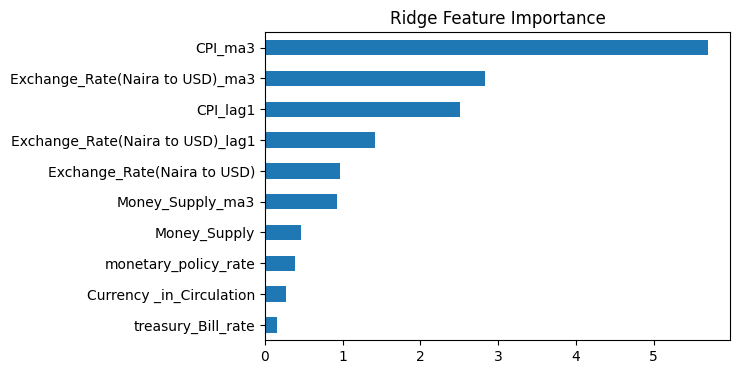

In [12]:
coefs = pd.Series(best_model.named_steps['ridge'].coef_, index=X_train.columns)
top10_r = coefs.abs().sort_values(ascending=False).head(10)

print("\nRidge Top-10 Features by |coef|:")
print(top10_r)

# bar chart
top10_r.sort_values().plot(kind='barh', figsize=(6,4))
plt.title("Ridge Feature Importance")
plt.show()

8.  TRAINING SVR DEFAULT

In [13]:
svr_def = SVR()
svr_def.fit(X_train_scaled, y_train)

y_tr_s_def = svr_def.predict(X_train_scaled)
y_te_s_def = svr_def.predict(X_test_scaled)

print("\nSVR (default) Performance")
print_metrics(" Train", y_train, y_tr_s_def)
print_metrics(" Test ", y_test,  y_te_s_def)


SVR (default) Performance
 Train → RMSE: 0.464, MAE: 0.256, R²: 0.976
 Test  → RMSE: 11.079, MAE: 9.138, R²: -2.794


9. SVR TUNING

In [ ]:
import numpy as np
import pandas as pd
import math

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Build the pipeline: scaling → SVR
svr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svr",    SVR(kernel="rbf"))
])

# 2. Hyperparameter grid for C, epsilon, and gamma
param_grid = {
    "svr__C":       np.logspace(-2, 3, 6),       # 0.01 … 100
    "svr__epsilon": [0.05, 0.1, 0.2, 0.3],       # tube widths
    "svr__gamma":   ["scale", "auto"]            # kernel coefficient
}

# 3. Respect time order with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=4)

# 4. Track multiple metrics; refit on RMSE
scoring = {
    "rmse": "neg_root_mean_squared_error",
    "mae":  "neg_mean_absolute_error",
    "r2":   "r2"
}

grid_svr = GridSearchCV(
    estimator=svr_pipeline,
    param_grid=param_grid,
    cv=tscv,
    scoring=scoring,
    refit="rmse",
    return_train_score=True,
    n_jobs=-1
)

# 5. Fit on training data
grid_svr.fit(X_train, y_train)

# 6. Extract best model and params
best_svr   = grid_svr.best_estimator_
best_params = grid_svr.best_params_
print("Best SVR params (by CV RMSE):", best_params)

# 7. Evaluate on train & test
y_pred_train = best_svr.predict(X_train)
y_pred_test  = best_svr.predict(X_test)

metrics = {
    "R2_train":  r2_score(y_train, y_pred_train),
    "R2_test":   r2_score(y_test,  y_pred_test),
    "MAE_test":  mean_absolute_error(y_test,  y_pred_test),
    "RMSE_test": math.sqrt(mean_squared_error(y_test, y_pred_test))
}

print("\nHold-out performance:")
for name, val in metrics.items():
    print(f"  {name}: {val:.4f}")

# 8. (Optional) CV summary across alphas/epsilons/gammas
cv_results = pd.DataFrame(grid_svr.cv_results_)
cols = [
    "param_svr__C", "param_svr__epsilon", "param_svr__gamma",
    "mean_train_rmse", "mean_test_rmse",
    "mean_train_r2",   "mean_test_r2"
]
print("\nCV summary:")
print(cv_results[cols].sort_values(cols[:3]).to_string(index=False))

10.  CROSSVALIDATION CHECK FOR GAPS

In [ ]:
cv_s = pd.DataFrame(grid_svr.cv_results_)
top3_s = cv_s.sort_values('mean_test_rmse', ascending=False).head(3)

print("\nTop 3 SVR CV candidates (by RMSE):")
print(top3_s[['param_svr__C','param_svr__gamma','mean_train_rmse','mean_test_rmse', 'mean_train_r2', 'mean_test_r2']])

# evaluate tuned SVR
y_tr_s = best_svr.predict(X_train)
y_te_s = best_svr.predict(X_test)

print("\nSVR (tuned) Performance")
print_metrics(" Train", y_train, y_tr_s)
print_metrics(" Test ", y_test,  y_te_s)

# CV train vs CV val
mask_s = (
    (cv_s['param_svr__C']==best_svr.get_params()['svr__C']) &
    (cv_s['param_svr__gamma']==best_svr.get_params()['svr__gamma'])
)
print(f"\nSVR CV Train R²: {cv_s.loc[mask_s,'mean_train_r2'].values[0]:.3f}, "
      f"CV Val R²: {cv_s.loc[mask_s,'mean_test_r2'].values[0]:.3f}")

11.  PLOTS

In [ ]:
# Actual vs Predicted (Ridge)
y_hat_r = y_te_r
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_hat_r, alpha=0.6)
plt.plot([y_test.min(),y_test.max()],
         [y_test.min(),y_test.max()],
         'r--')
plt.title("Actual vs Predicted (Ridge)")
plt.xlabel("Actual CPI"); plt.ylabel("Predicted CPI")
plt.show()

# Residuals vs Predicted (Ridge)
resid_r = y_test - y_hat_r
plt.figure(figsize=(6,4))
plt.scatter(y_hat_r, resid_r, alpha=0.6)
plt.hlines(0, y_hat_r.min(), y_hat_r.max(), colors='r', linestyles='dashed')
plt.title("Residuals vs Predicted (Ridge)")
plt.xlabel("Predicted CPI"); plt.ylabel("Residuals")
plt.show()

# Actual vs Predicted (SVR)
y_hat_s = y_te_s
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_hat_s, alpha=0.6)
plt.plot([y_test.min(),y_test.max()],
         [y_test.min(),y_test.max()],
         'r--')
plt.title("Actual vs Predicted (SVR)")
plt.xlabel("Actual CPI"); plt.ylabel("Predicted CPI")
plt.show()

# Residuals vs Predicted (SVR)
resid_s = y_test - y_hat_s
plt.figure(figsize=(6,4))
plt.scatter(y_hat_s, resid_s, alpha=0.6)
plt.hlines(0, y_hat_s.min(), y_hat_s.max(), colors='r', linestyles='dashed')
plt.title("Residuals vs Predicted (SVR)")
plt.xlabel("Predicted CPI"); plt.ylabel("Residuals")
plt.show()

12.   PERMUTATION IMPORTANCES

In [ ]:
imp = permutation_importance(best_svr, X_test_scaled, y_test,
                             n_repeats=10, random_state=0)
feat_imp = pd.Series(imp.importances_mean, index=X.columns)
top10_s = feat_imp.sort_values(ascending=False).head(10)

print("\nSVR Permutation Top-10 Features:")
print(top10_s)

top10_s.sort_values().plot(kind='barh', figsize=(6,4))
plt.title("SVR Feature Importance")
plt.show()